# Appendix 04 - Exploring Clustering Methods: *Deterministic and Stochastic approaches*

In [76]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from models.deterministic_radially_constrained_cluster import *  # Adjust import as per your package structure
from models.radially_constrained_cluster import *
from models.X_RCC import XRCC
from visualization.custom_plots import standard_format, day_of_year_to_date
import itertools

In [77]:
# -- PARAMETERS 

# Common parameters
n_seas = 2
min_len= 1
metric = 'euclidean'

# Deterministic model parameters
n_days = list(np.arange(0,365,5))

# Stochastic model parameters
iters = 300
learning_rate   = 1

starting_bp     = [50, 330]

lat = 28
lon = 80

In [78]:
dataset_t2m = xr.open_mfdataset(rf'../INDIA/data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load().sel(lat=lat, lon=lon, method='nearest')
dataset_tp = xr.open_mfdataset(rf'../INDIA/data/preprocessed/ERA5/total_precipitation/final.nc').tp.load().sel(lat=lat, lon=lon, method='nearest')
dataset_u100 = xr.open_mfdataset(rf'../INDIA/data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load().sel(lat=lat, lon=lon, method='nearest')
dataset_v100 = xr.open_mfdataset(rf'../INDIA/data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load().sel(lat=lat, lon=lon, method='nearest')

dataset_tp['time'] = dataset_t2m['time']
dataset_u100['time'] = dataset_t2m['time']
dataset_v100['time'] = dataset_t2m['time']

datasets = [dataset_tp, dataset_u100, dataset_v100]  # Add as many datasets as needed

In [79]:
datasets_tab = [dataset.to_dataframe() for dataset in datasets]

datasets_tab = [dataset.dropna() for dataset in datasets_tab]
datasets_tab = pd.concat(datasets_tab, axis=1)

datasets_tab = datasets_tab.drop(columns=['lon','lat','spatial_ref'])
# Remove hours from datetime
datasets_tab.index = pd.to_datetime(datasets_tab.index.astype(str))

In [80]:
# Reshape the table to keep the day of the year as the index and for the columns the values of the different variables at each year.
# The final shape will be 365 * n_years x n_variables. Remove the empy values
datasets_tab_res = datasets_tab.pivot_table(index=datasets_tab.index.dayofyear, columns=datasets_tab.index.year)
datasets_tab_res.columns = [f'{var}_{year}' for var, year in datasets_tab_res.columns]
datasets_tab_res

,tp_1969,tp_1970,tp_1971,tp_1972,tp_1973,tp_1974,tp_1975,tp_1976,tp_1977,tp_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,0.000006,0.000000e+00,0.0,0.000000e+00,6.369970e-06,3.311369e-09,1.442782e-05,3.679299e-10,8.094458e-09,1.679342e-05,...,-0.757658,-0.762310,-1.397434,-0.609624,-0.994971,-1.025588,-0.947749,-1.146635,-0.393102,-0.767026
2,0.000002,0.000000e+00,0.0,0.000000e+00,6.426632e-06,3.311369e-09,1.492600e-05,3.679299e-10,8.094458e-09,1.682212e-05,...,-0.799099,-0.709980,-1.438688,-0.674785,-1.034110,-0.940446,-0.930903,-1.177706,-0.598872,-0.704788
3,0.000001,0.000000e+00,0.0,0.000000e+00,6.426632e-06,3.311369e-09,1.507795e-05,3.679299e-10,0.000000e+00,1.195662e-05,...,-0.904859,-0.679166,-1.406034,-0.738758,-1.128538,-0.723004,-0.821817,-1.199870,-0.620023,-0.691203
4,0.000001,7.321805e-08,0.0,0.000000e+00,1.886929e-05,3.311369e-09,1.508825e-05,3.679299e-10,5.077433e-08,4.043918e-06,...,-0.993890,-0.675825,-1.342501,-0.776968,-1.154907,-0.716395,-0.734977,-1.125410,-0.677776,-0.738319
5,0.000003,7.321805e-08,0.0,0.000000e+00,2.096538e-05,3.311369e-09,1.509598e-05,3.679299e-10,5.077433e-08,4.518179e-07,...,-1.108445,-0.593472,-1.308078,-0.876247,-1.150051,-0.546216,-0.668302,-0.977807,-0.666004,-0.714043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.000000,0.000000e+00,0.0,9.533064e-07,0.000000e+00,1.442782e-05,3.679299e-10,8.094458e-09,1.679342e-05,0.000000e+00,...,-1.086702,-1.320573,-1.021151,-0.756301,-0.949801,-0.738872,-1.235355,-0.524321,-0.791924,-1.330765
363,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.442782e-05,3.679299e-10,8.094458e-09,1.679342e-05,0.000000e+00,...,-1.049502,-1.315273,-1.005877,-0.719653,-1.080182,-0.812677,-1.273662,-0.348308,-0.746334,-1.181522
364,0.000000,0.000000e+00,0.0,1.655684e-08,3.679299e-10,1.442782e-05,3.679299e-10,8.094458e-09,1.679342e-05,0.000000e+00,...,-0.949331,-1.381602,-0.707459,-0.748219,-1.169332,-0.914205,-1.204041,-0.254778,-0.740771,-1.251708


In [81]:
dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.min(axis=0))/(datasets_tab_res.max(axis=0) - datasets_tab_res.min(axis=0))
#dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.mean(axis=0))/datasets_tab_res.std(axis=0)
dataset_tab_res_norm

,tp_1969,tp_1970,tp_1971,tp_1972,tp_1973,tp_1974,tp_1975,tp_1976,tp_1977,tp_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,0.028516,0.000000,0.0,0.000000,0.027284,0.00001,3.600122e-02,0.000002,0.000036,0.084858,...,0.464673,0.436834,0.314472,0.569587,0.395545,0.553384,0.300502,0.290038,0.557667,0.420728
2,0.011257,0.000000,0.0,0.000000,0.027527,0.00001,3.724431e-02,0.000002,0.000036,0.085003,...,0.454174,0.449481,0.305677,0.555343,0.386788,0.573253,0.304986,0.281873,0.500699,0.442589
3,0.005220,0.000000,0.0,0.000000,0.027527,0.00001,3.762347e-02,0.000002,0.000000,0.060417,...,0.427382,0.456927,0.312639,0.541359,0.365661,0.623996,0.334021,0.276048,0.494844,0.447361
4,0.005220,0.000503,0.0,0.000000,0.080822,0.00001,3.764918e-02,0.000002,0.000224,0.020434,...,0.404827,0.457735,0.326183,0.533006,0.359761,0.625539,0.357135,0.295616,0.478855,0.430811
5,0.013229,0.000503,0.0,0.000000,0.089800,0.00001,3.766846e-02,0.000002,0.000224,0.002283,...,0.375807,0.477638,0.333522,0.511304,0.360848,0.665253,0.374881,0.334405,0.482114,0.439338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.000000,0.000000,0.0,0.005385,0.000000,0.04199,9.180824e-07,0.000043,0.073973,0.000000,...,0.381315,0.301914,0.394693,0.537524,0.405651,0.620293,0.223951,0.453580,0.447253,0.222710
363,0.000000,0.000000,0.0,0.000000,0.000000,0.04199,9.180824e-07,0.000043,0.073973,0.000000,...,0.390739,0.303196,0.397949,0.545535,0.376480,0.603070,0.213755,0.499835,0.459874,0.275133
364,0.000000,0.000000,0.0,0.000094,0.000002,0.04199,9.180824e-07,0.000043,0.073973,0.000000,...,0.416116,0.287165,0.461569,0.539290,0.356534,0.579376,0.232286,0.524414,0.461415,0.250480


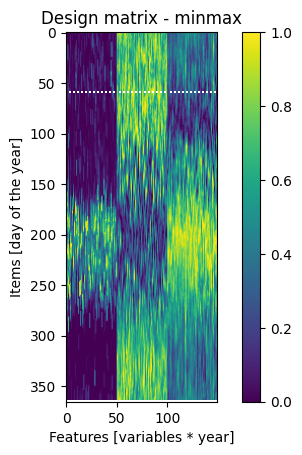

In [82]:
plt.figure()
plt.imshow(dataset_tab_res_norm.values)
plt.xlabel('Features [variables * year]')
plt.ylabel('Items [day of the year]')
plt.title('Design matrix - minmax')
plt.colorbar()

In [83]:
arrays = []
weights = [1,0.5,0.5]
for grid_points_var in datasets:
    grid_points_var = np.asarray(grid_points_var)
    grid_points_var = np.reshape(grid_points_var, (365, int(grid_points_var.size/365)), order='F')
    
    if np.isnan(grid_points_var).any():
        array_tot = (np.full(n_seas, np.nan), np.full(iters, np.nan), np.full(iters, np.nan))
    
    arrays.append(grid_points_var)

combined_mask = ~np.any([np.all(np.isnan(arr), axis=0) for arr in arrays], axis=0)

normalized_arrays = []
for arr, weight in zip(arrays, weights):
    array_tot = arr[:, combined_mask]
    array_tot = (array_tot - array_tot.min(axis=0)) / (array_tot.max(axis=0) - array_tot.min(axis=0))
    #array_tot = (array_tot - array_tot.mean(axis=0)) / array_tot.std(axis=0)
    normalized_arrays.append(array_tot*weight)

array_tot = np.concatenate(normalized_arrays, axis=1)


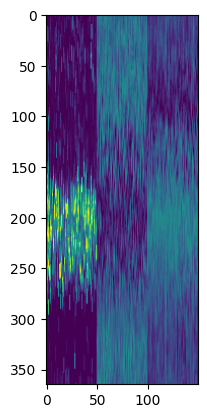

In [84]:
plt.imshow(array_tot)

In [85]:
from sklearn.metrics import silhouette_score

best, err, bp_list = single_fit_optimized(array_tot, n_seas, n_days, metric=metric)

2628it [00:02, 1086.39it/s]


43424719800.0

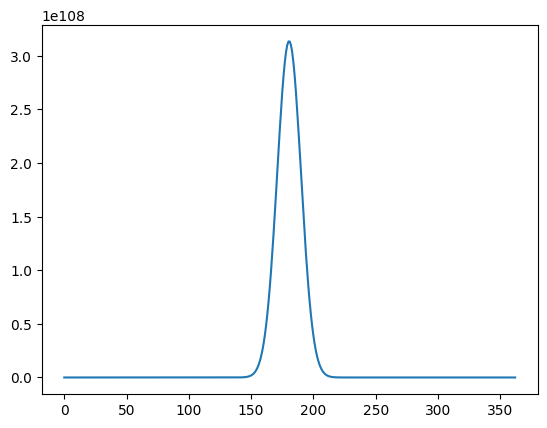

In [86]:
# Compute binomial coefficient
import scipy.special

# Plot the binomial of 365,n with n in x axis
plt.figure()
plt.plot([scipy.special.binom(365, n) for n in range(2,365)])

scipy.special.binom(180, 6)

In [87]:
# # Costruisci variabili indipendenti dinamicamente dalle combinazioni
# variables = np.array(list(combinations(n_days, n_seas))).T  # Variabili indipendenti in forma (n_dimensions, n_combinations)

# # Definiamo X_grid come la meshgrid multidimensionale di ciascuna variabile
# unique_vars = [np.unique(var) for var in variables]
# grids = np.meshgrid(*unique_vars, indexing='ij')  # Griglia multidimensionale per tutte le variabili

# # Creare Z con una dimensione extra per le dimensioni di err
# Z = np.empty(grids[0].shape + (n_seas,))  # Z ha le dimensioni della griglia e una dimensione extra per err

# # Riempimento di Z con valori medi per ciascuna combinazione unica delle variabili
# for index in np.ndindex(grids[0].shape):  # Itera su tutti gli indici della griglia
#     # Trova gli indici che corrispondono a ciascuna combinazione di variabili
#     indices = np.all([variables[i] == grids[i][index] for i in range(len(variables))], axis=0)
    
#     # Calcola la media se esistono valori corrispondenti
#     if np.any(indices):
#         Z[index] = np.mean(err[indices], axis=0)
#     else:
#         Z[index] = np.nan  # Riempire con NaN se nessun valore corrisponde

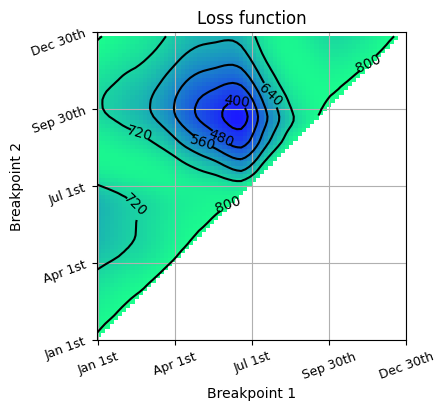

In [88]:
x = np.array(list(combinations(n_days, n_seas))).squeeze()[:,0]
y = np.array(list(combinations(n_days, n_seas))).squeeze()[:,1]


# # Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

        

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='winter', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

Text(0, 0.5, 'WCSS')

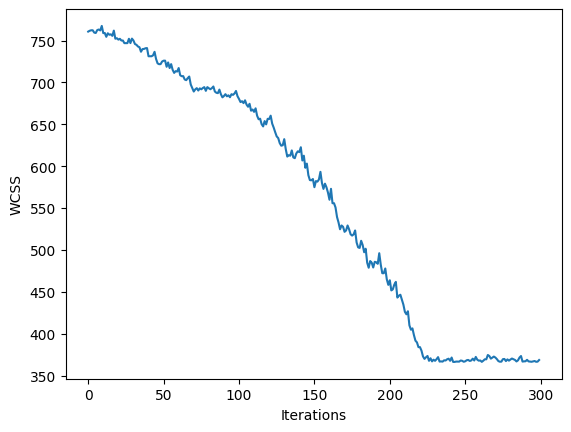

In [89]:
clustering_params = {
        'n_iter': iters,
        'n_seas': n_seas,
        'learning_rate': 3,
        'scheduling_factor':1,
        'min_len': 1,
        'mode': 'single',
        'starting_bp': list(np.sort(np.random.randint(0, 365, n_seas))),
        'metric': metric,
    }

model = Radially_Constrained_Cluster(array_tot, **clustering_params)

model.fit()

plt.plot(model.error_history)
plt.xlabel('Iterations')
plt.ylabel('WCSS')

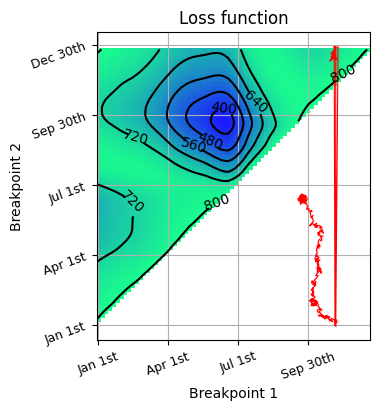

In [90]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='winter', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.8, markersize=0.1)

In [91]:
model.breakpoints

array([166, 266], dtype=int32)

In [92]:
# Import the reference dates

literature_results_path  = f'../data/preprocessed/external/monsoon_dates.nc'
literature_results = xr.open_dataset(literature_results_path).drop('spatial_ref')

FileNotFoundError: [Errno 2] No such file or directory: '/work/users/jgrassi/XSeasonsDetect/data/preprocessed/external/monsoon_dates.nc'

In [ ]:
literature_results_point = literature_results.sel(lat=lat, lon=lon, method='nearest')
literature_results_point.date.values

array([175.03559031, 273.87781213])

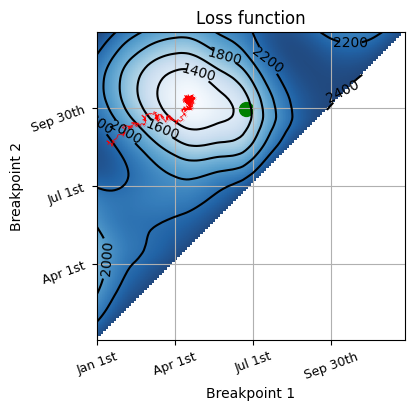

In [ ]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='Blues', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.5, markersize=0.1)
plt.scatter(literature_results_point.date.values[0], literature_results_point.date.values[1], marker='o', color='green', s=100)